✅ Carregou lista local de 403 tickers de 'acoes-listadas-b3.csv'



1 Failed download:
['AZTE3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-02 -> 2025-01-30) (Yahoo error = "Data doesn\'t exist for startDate = 1577934000, endDate = 1738206000")')

1 Failed download:
['ELMD3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-02 -> 2025-01-30) (Yahoo error = "Data doesn\'t exist for startDate = 1577934000, endDate = 1738206000")')

1 Failed download:
['AZEV11.SA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['AMAR11.SA']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CCRO3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-02 -> 2025-01-30) (Yahoo error = "No data found, symbol may be delisted")')


✅ Séries baixadas com sucesso: 393 tickers (falhas ignoradas)
Top 10 tickers por variação absoluta (%) no período: [('NUTR3.SA', 'NUTR3.SA'), ('BMEB4.SA', 'BMEB4.SA'), ('BMEB3.SA', 'BMEB3.SA'), ('PRIO3.SA', 'PRIO3.SA'), ('CPLE5.SA', 'CPLE5.SA'), ('CEBR6.SA', 'CEBR6.SA'), ('FRIO3.SA', 'FRIO3.SA'), ('RSUL4.SA', 'RSUL4.SA'), ('MNPR3.SA', 'MNPR3.SA'), ('CEBR3.SA', 'CEBR3.SA')]


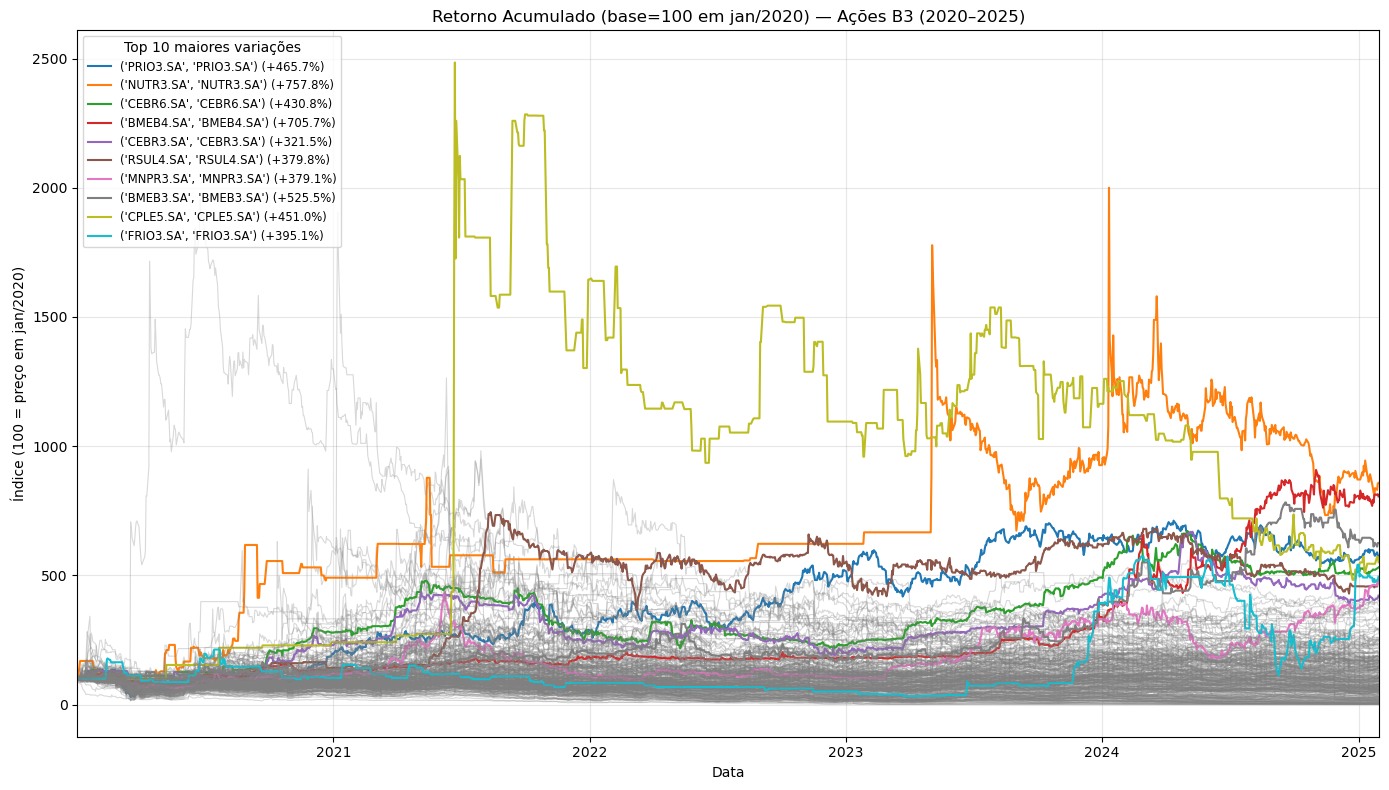

In [32]:
import os
import time
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Montar lista de tickers B3 (.SA)
RAW_URL = "https://raw.githubusercontent.com/wilsonfreitas/ticker_list/main/br.csv"
try:
    resp = requests.get(RAW_URL, timeout=10)
    resp.raise_for_status()
    tickers_df = pd.read_csv(pd.io.common.StringIO(resp.text))
    print(f"✅ Baixou lista de {len(tickers_df)} tickers do GitHub")
except Exception:
    LOCAL_FILE = "acoes-listadas-b3.csv"
    tickers_df = pd.read_csv(LOCAL_FILE)
    print(f"✅ Carregou lista local de {len(tickers_df)} tickers de '{LOCAL_FILE}'")

tickers = tickers_df["Ticker"].str.strip().astype(str).tolist()
tickers = [t for t in tickers if t.upper() != "SNSY3"]

# --- ALTERAÇÃO 1: EXCLUIR O TICKER 'TIMS3' ---
tickers = [t for t in tickers if t.upper() != "TIMS3"]
# -----------------------------------------------

tickers = [t + ".SA" for t in tickers]

# (Para testes rápidos, você pode descomentar abaixo)
# tickers = tickers[:50]

# 2) Loop de download com retry, ignorando falhas
start, end = "2020-01-02", "2025-01-30"
all_series = {}

for tk in tickers:
    for attempt in range(3):
        try:
            s = yf.download(
                tk,
                start=start,
                end=end,
                progress=False,
                timeout=30
            )["Close"]
            if not s.empty:
                all_series[tk] = s
            break
        except Exception:
            time.sleep(2)
    # se falhar todas as tentativas, simplesmente ignora

print(f"✅ Séries baixadas com sucesso: {len(all_series)} tickers (falhas ignoradas)")

# 3) Construir DataFrame único alinhado em business days
combined = pd.concat(
    list(all_series.values()),
    axis=1,
    keys=list(all_series.keys())
)
combined = combined.asfreq('B').ffill()

# 4) Filtrar tickers sem base e normalizar
jan2020 = combined.loc["2020-01-02":"2020-01-31"]
first_date = jan2020.dropna(how="all").index[0]
valid_tickers = combined.columns[combined.loc[first_date].notna()]
combined = combined[valid_tickers]
base = combined.loc[first_date]
norm = combined.div(base).mul(100)

# 5) Determinar top 10 variações percentuais
final_date = norm.loc["2025-01-02":"2025-01-30"].dropna(how="all").index[-1]
pct_change = norm.loc[final_date] - 100
top10 = pct_change.abs().sort_values(ascending=False).head(10).index.tolist()
print("Top 10 tickers por variação absoluta (%) no período:", top10)

# 6) Plotar todas as séries, mas legendar apenas as top 10
plt.figure(figsize=(14, 8))
for tk in norm.columns:
    if tk in top10:
        plt.plot(
            norm.index, norm[tk],
            label=f"{tk} ({pct_change[tk]:+.1f}%)",
            linewidth=1.5
        )
    else:
        plt.plot(
            norm.index, norm[tk],
            color='gray', alpha=0.3, linewidth=0.8
        )

plt.title("Retorno Acumulado (base=100 em jan/2020) — Ações B3 (2020–2025)")
plt.xlabel("Data")
plt.ylabel("Índice (100 = preço em jan/2020)")
plt.xlim(pd.Timestamp("2020-01-02"), pd.Timestamp("2025-01-30"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(alpha=0.3)
plt.legend(title="Top 10 maiores variações", loc="upper left", fontsize="small")
plt.tight_layout()

# --- ALTERAÇÃO 2: SALVAR A IMAGEM ---
# Salva a figura com alta resolução (dpi=300) e remove bordas brancas.
plt.savefig('retorno_acumulado_b3_2020-2025.png', dpi=300, bbox_inches='tight')
# --------------------------------------

plt.show() # O comando para salvar deve vir ANTES de show()

Top 10 tickers por pico máximo no período: [('CPLE5.SA', 'CPLE5.SA'), ('NUTR3.SA', 'NUTR3.SA'), ('PPLA11.SA', 'PPLA11.SA'), ('BSLI3.SA', 'BSLI3.SA'), ('FHER3.SA', 'FHER3.SA'), ('INEP4.SA', 'INEP4.SA'), ('INEP3.SA', 'INEP3.SA'), ('OSXB3.SA', 'OSXB3.SA'), ('BMEB4.SA', 'BMEB4.SA'), ('ETER3.SA', 'ETER3.SA')]


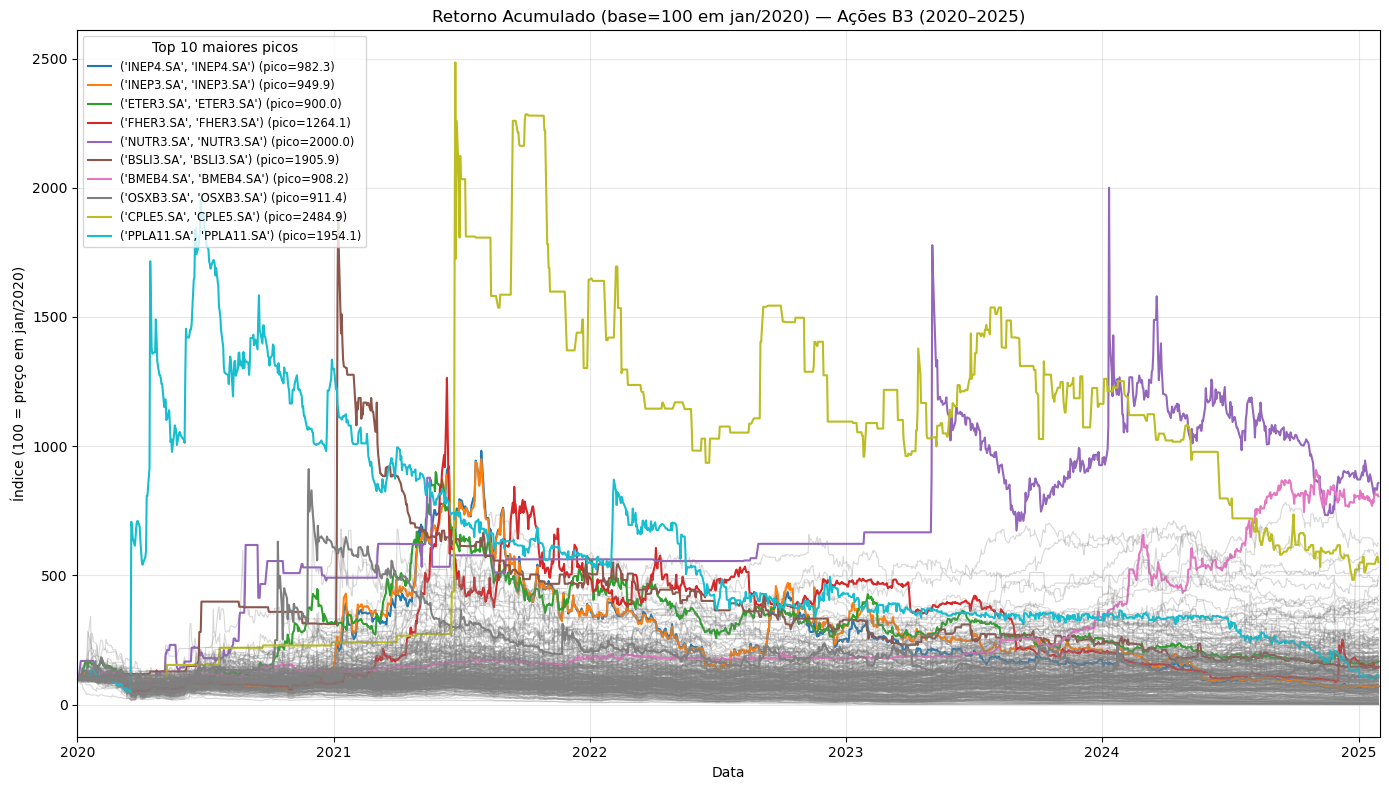

In [34]:
# --- ADICIONE ESTA LINHA PARA EXCLUIR O TICKER ---
# Garante que o ticker será removido, mesmo que não esteja presente (errors='ignore')
if 'TIMS3.SA' in norm.columns:
    norm = norm.drop(columns=['TIMS3.SA'])
# ---------------------------------------------

# 5) Determinar top 10 picos máximos de jan2020 a jan2025
max_vals = norm.max()                                  # máximo de cada ticker
top10 = max_vals.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 tickers por pico máximo no período:", top10)

# 6) Plotar todas as séries, mas legendar apenas as top 10
plt.figure(figsize=(14, 8))
for tk in norm.columns:
    if tk in top10:
        plt.plot(
            norm.index, norm[tk],
            label=f"{tk} (pico={max_vals[tk]:.1f})",
            linewidth=1.5
        )
    else:
        plt.plot(
            norm.index, norm[tk],
            color='gray', alpha=0.3, linewidth=0.8
        )

plt.title("Retorno Acumulado (base=100 em jan/2020) — Ações B3 (2020–2025)")
plt.xlabel("Data")
plt.ylabel("Índice (100 = preço em jan/2020)")
plt.xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-01-31"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(alpha=0.3)
plt.legend(title="Top 10 maiores picos", loc="upper left", fontsize="small")
plt.tight_layout()

# --- ADICIONE ESTA LINHA PARA SALVAR O GRÁFICO ---
plt.savefig('picos_maximos_b3_2020-2025.png', dpi=300, bbox_inches='tight')
# -------------------------------------------------

plt.show()

In [36]:
# 1. Pegar o último valor de cada ação no período analisado
final_values = norm.loc["2025-01-01":"2025-01-31"].iloc[-1]

# 2. Ordenar do maior para o menor
top10 = final_values.sort_values(ascending=False).head(10)

# 3. Exibir o resultado
print("Top 10 ações com maior valorização no período (jan/2020 a jan/2025):")
print(top10)


Top 10 ações com maior valorização no período (jan/2020 a jan/2025):
          Ticker  
NUTR3.SA  NUTR3.SA    857.777777
BMEB4.SA  BMEB4.SA    805.675636
BMEB3.SA  BMEB3.SA    625.486532
PRIO3.SA  PRIO3.SA    565.747906
CPLE5.SA  CPLE5.SA    550.990026
CEBR6.SA  CEBR6.SA    530.806195
FRIO3.SA  FRIO3.SA    495.081967
RSUL4.SA  RSUL4.SA    479.819623
MNPR3.SA  MNPR3.SA    479.057603
CEBR3.SA  CEBR3.SA    421.494531
Name: 2025-01-29 00:00:00, dtype: float64


Top10 tickers: ['NUTR3.SA', 'BMEB4.SA', 'BMEB3.SA', 'PRIO3.SA', 'CPLE5.SA', 'CEBR6.SA', 'FRIO3.SA', 'RSUL4.SA', 'MNPR3.SA', 'CEBR3.SA']
Matriz de correlação dos retornos diários das top10:
           NUTR3.SA  BMEB4.SA  BMEB3.SA  PRIO3.SA  CPLE5.SA  CEBR6.SA  \
NUTR3.SA  1.000000 -0.027318 -0.000614 -0.002746  0.004153 -0.004998   
BMEB4.SA -0.027318  1.000000  0.229103  0.101838  0.009831  0.026197   
BMEB3.SA -0.000614  0.229103  1.000000  0.009928 -0.010835  0.028949   
PRIO3.SA -0.002746  0.101838  0.009928  1.000000 -0.006854  0.061629   
CPLE5.SA  0.004153  0.009831 -0.010835 -0.006854  1.000000  0.007639   
CEBR6.SA -0.004998  0.026197  0.028949  0.061629  0.007639  1.000000   
FRIO3.SA  0.043308 -0.000681 -0.005184  0.027239  0.008337  0.018770   
RSUL4.SA  0.038611  0.015945  0.001865  0.034061  0.002922 -0.040874   
MNPR3.SA -0.001350  0.056645  0.012396  0.116305 -0.001846  0.003015   
CEBR3.SA -0.018314  0.020528  0.012343  0.103113  0.043236  0.390835   

          FRIO3.S

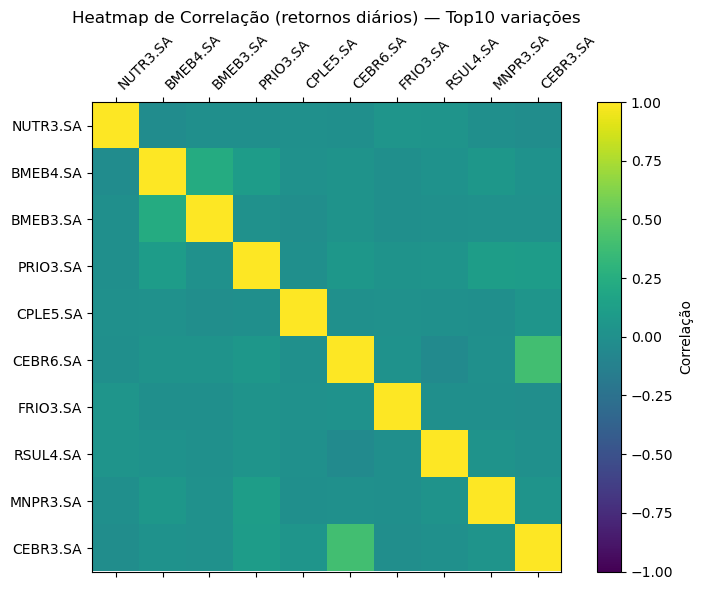

In [40]:


# --- Supondo que você já tenha ---
# combined : DataFrame com preços raw alinhados e ffilled
# norm     : DataFrame com preços normalizados (100 em jan/2020)

# 1) Identificar a data final exata (último pregão de jan/2025)
final_date = norm.loc["2025-01-01":"2025-01-31"].dropna(how="all").index[-1]

# 2) Extrair os valores normalizados nessa data
final_vals = norm.loc[final_date]

# 3) Selecionar top10 tickers por variação absoluta (|valor−100|)
top10_tickers = final_vals.sub(100).abs().nlargest(10).index.tolist()
print("Top10 tickers:", top10_tickers)

# 4) Criar DataFrame apenas com esses top10
top10_norm = norm[top10_tickers]

# 5) Calcular retornos diários percentuais
returns = top10_norm.pct_change().dropna()

# 6) Gerar matriz de correlação
corr_matrix = returns.corr()
print("Matriz de correlação dos retornos diários das top10:\n", corr_matrix)

# 7) Plotar um heatmap simples
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1)
fig.colorbar(cax, label="Correlação")
ax.set_xticks(range(len(top10_tickers)))
ax.set_yticks(range(len(top10_tickers)))
ax.set_xticklabels(top10_tickers, rotation=45, ha="left")
ax.set_yticklabels(top10_tickers)
plt.title("Heatmap de Correlação (retornos diários) — Top10 variações")
plt.tight_layout()
plt.show()



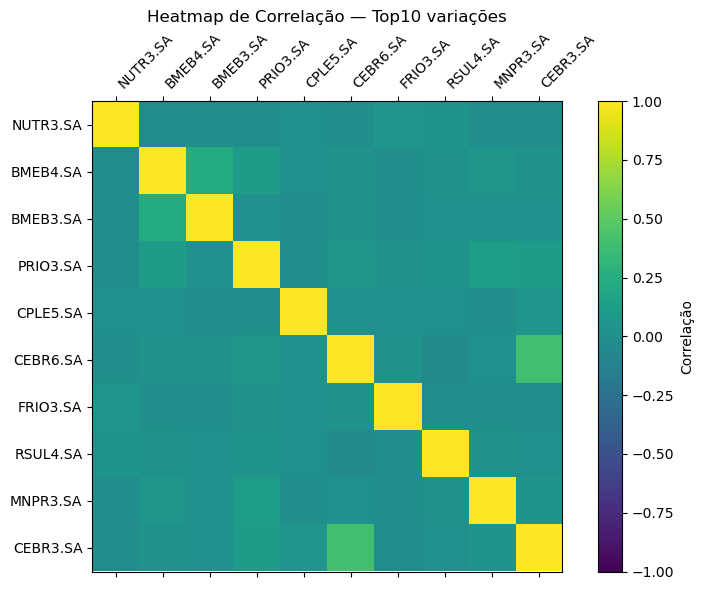

In [38]:
# --- 1) Concat correto ---
combined = pd.concat(
    all_series.values(),
    axis=1,
    keys=all_series.keys()
).asfreq('B').ffill()

# ... segue o seu filtro/normalização até gerar `norm` ...

# --- 2) Garantir colunas planas --- 
import pandas as pd
if isinstance(norm.columns, pd.MultiIndex):
    norm.columns = norm.columns.get_level_values(0)

# --- 3) Agora calcula top10 e correlação normalmente ---
final_date   = norm.loc["2025-01-01":"2025-01-31"].dropna(how="all").index[-1]
final_vals   = norm.loc[final_date]
top10        = final_vals.sub(100).abs().nlargest(10).index.tolist()

returns      = norm[top10].pct_change().dropna()
corr_matrix  = returns.corr()

# --- 4) Plot heatmap ---
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1)
fig.colorbar(cax, label="Correlação")
ax.set_xticks(range(len(top10)))
ax.set_yticks(range(len(top10)))
ax.set_xticklabels(top10, rotation=45, ha="left")
ax.set_yticklabels(top10)
plt.title("Heatmap de Correlação — Top10 variações")
plt.tight_layout()
plt.savefig('heatmap_correlacao_b3_2020-2025.png', dpi=300, bbox_inches='tight')
plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



C:\Users\Rodrigo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 8.0788e-04 - val_loss: 0.0023
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 6.5134e-04 - val_loss: 0.0022
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 5.4408e-04 - val_loss: 0.0021
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 5.2583e-04 - val_loss: 0.0026
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 4.6191e-04 - val_loss: 0.0020
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 4.3242e-04 - val_loss: 0.0019
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 4.7153e-04 - val_loss: 0.0022
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.8259e-04 - val_loss: 0.0029
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 4.1935e-04 - val_loss: 0.0026
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 3.8361e-04 - val_loss: 0.0025
Epoch 12/50
89/89 ━━━━━━━━━━━━━━

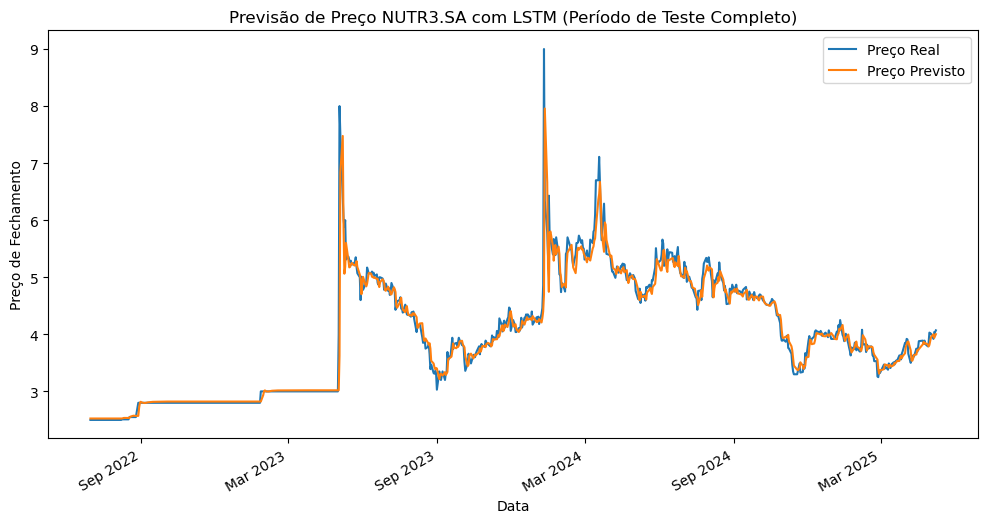


Exibindo e salvando gráfico para o período de 2020-01-01 a 2025-01-31.


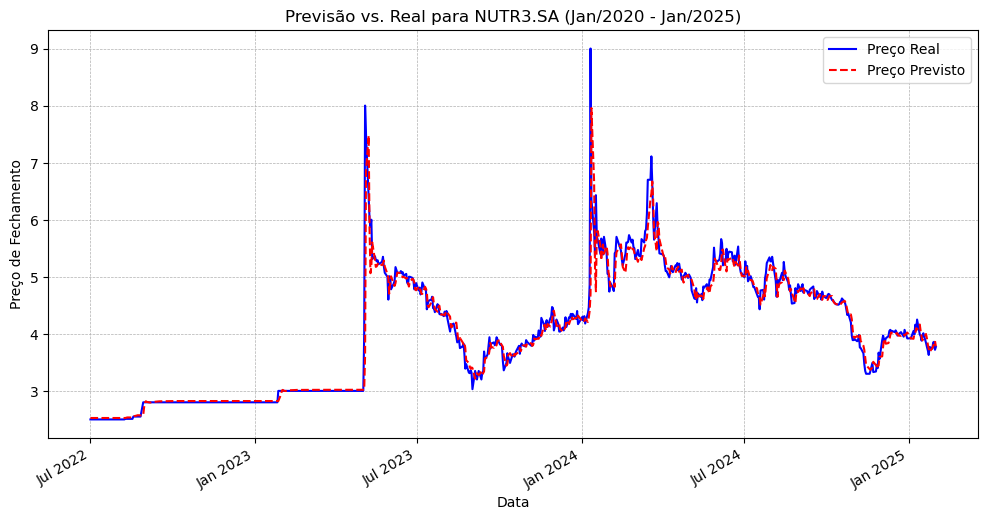

MAE:  0.11 BRL
RMSE: 0.29 BRL
MAPE: 2.29%
R²:   0.9194


In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Baixar dados da PETR4 e isolar 'Close'
ticker = "NUTR3.SA"
df = yf.download(ticker, start="2007-02-02", end="2025-05-09")
df = df[['Close']]  # DataFrame n×1

# 2. Pré-processamento (normalização só em Close)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)  # shape (n,1)

# 3. Preparar os dados para LSTM
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 90  # usar 90 dias anteriores
X, y = prepare_data(scaled_data, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))  # formato (amostras, timesteps, features)

# 4. Dividir em treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Treinar o modelo com Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# 7. Gerar previsões e desnormalizar
predicted_scaled = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_scaled)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 8. Montar DataFrame de comparação
# ... (código igual ao anterior) ...
comparison_df = pd.DataFrame({
    "Data": df.index[-len(y_test):],
    "Preço Real": y_test_real.flatten(),
    "Preço Previsto": predicted_prices.flatten()
})
comparison_df.set_index('Data', inplace=True)

# 9. Plotar e SALVAR resultados GERAIS (todo o período de teste)
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df["Preço Real"], label="Preço Real")
plt.plot(comparison_df.index, comparison_df["Preço Previsto"], label="Preço Previsto")
plt.legend()
plt.title(f"Previsão de Preço {ticker} com LSTM (Período de Teste Completo)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

# ADICIONE ESTA LINHA PARA SALVAR O PRIMEIRO GRÁFICO
plt.savefig(f'previsao_geral_{ticker}.png', dpi=300, bbox_inches='tight')

plt.show() # O show() vem depois de salvar

# 9.1. Plotar e SALVAR resultados destacando o período de Jan/2020 a Jan/2025
start_date = "2020-01-01"
end_date = "2025-01-31"

highlight_df = comparison_df[
    (comparison_df.index >= start_date) & 
    (comparison_df.index <= end_date)
]

if not highlight_df.empty:
    print(f"\nExibindo e salvando gráfico para o período de {start_date} a {end_date}.")
    plt.figure(figsize=(12, 6))
    
    plt.plot(highlight_df.index, highlight_df["Preço Real"], label="Preço Real", color='blue')
    plt.plot(highlight_df.index, highlight_df["Preço Previsto"], label="Preço Previsto", color='red', linestyle='--')
    
    plt.legend()
    plt.title(f"Previsão vs. Real para {ticker} (Jan/2020 - Jan/2025)")
    plt.xlabel("Data")
    plt.ylabel("Preço de Fechamento")
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gcf().autofmt_xdate()
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # ADICIONE ESTA LINHA PARA SALVAR O SEGUNDO GRÁFICO
    plt.savefig(f'previsao_2020-2025_{ticker}.png', dpi=300, bbox_inches='tight')
    
    plt.show() # O show() vem depois de salvar
else:
    print(f"\nNão há dados de previsão no período de {start_date} a {end_date} para plotar.")

# 10. Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_test_real, predicted_prices))
r2  = r2_score(y_test_real, predicted_prices)
mae = mean_absolute_error(y_test_real, predicted_prices)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_real, predicted_prices)

print(f"MAE:  {mae:.2f} BRL")
print(f"RMSE: {rmse:.2f} BRL")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


Exibindo gráfico para o período de 2020-01-01 a 2025-01-31.


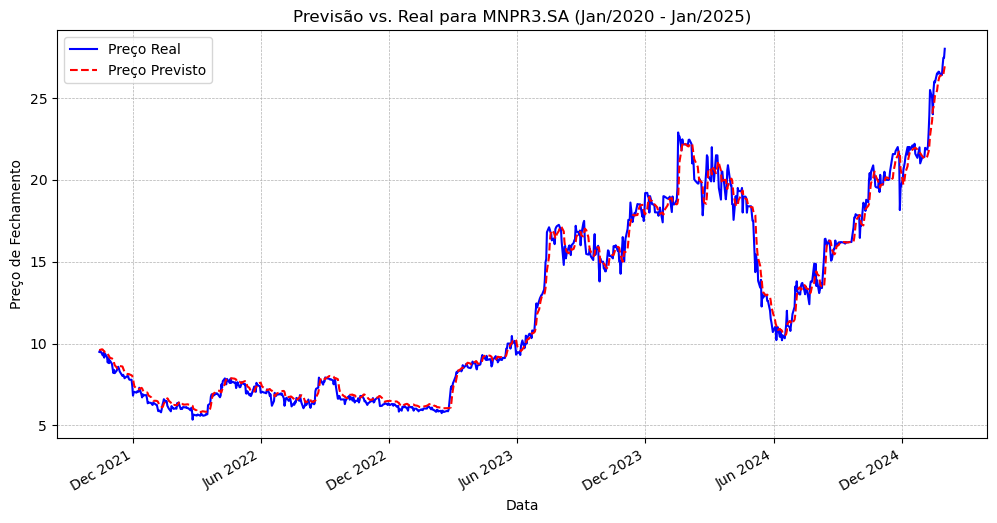

In [4]:
# --- NOVO BLOCO DE CÓDIGO PARA O GRÁFICO ESPECÍFICO ---

# 9.1. Plotar resultados destacando o período de Jan/2020 a Jan/2025

# Definir as datas de início e fim para o filtro
start_date = "2020-01-01"
end_date = "2025-01-31"

# Filtrar o DataFrame de comparação para o período desejado
highlight_df = comparison_df[
    (comparison_df['Data'] >= start_date) & 
    (comparison_df['Data'] <= end_date)
]

# Verificar se há dados no período para plotar
if not highlight_df.empty:
    print(f"\nExibindo gráfico para o período de {start_date} a {end_date}.")
    plt.figure(figsize=(12, 6))
    
    # Plotar os dados filtrados
    plt.plot(highlight_df["Data"], highlight_df["Preço Real"], label="Preço Real", color='blue')
    plt.plot(highlight_df["Data"], highlight_df["Preço Previsto"], label="Preço Previsto", color='red', linestyle='--')
    
    # Formatação do gráfico
    plt.legend()
    plt.title(f"Previsão vs. Real para {ticker} (Jan/2020 - Jan/2025)")
    plt.xlabel("Data")
    plt.ylabel("Preço de Fechamento")
    
    # Melhorar a formatação do eixo X
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) # Ajustar o intervalo dos meses se necessário
    plt.gcf().autofmt_xdate() # Rotaciona as datas para melhor visualização
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print(f"\nNão há dados de previsão no período de {start_date} a {end_date} para plotar.")

# --- FIM DO NOVO BLOCO DE CÓDIGO ---